In [1]:
%%configure -f
{ "conf":{
          "spark.pyspark.python": "python3",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv",
          "spark.sql.execution.arrow.enabled":"true"
         }
}

[I 2023-03-10 21:32:12,172.172 configure_magic] Magic cell payload received: {"conf": {"spark.pyspark.python": "python3", "spark.pyspark.virtualenv.enabled": "true", "spark.pyspark.virtualenv.type": "native", "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv", "spark.sql.execution.arrow.enabled": "true"}, "proxyUser": "assumed-role_fdp_blitvin-Isengard"}

[I 2023-03-10 21:32:12,173.173 configure_magic] Sending request to update kernel. Please wait while the kernel will be refreshed.


The kernel is successfully refreshed.

In [1]:
sc.install_pypi_package("dowhy")

In [2]:
import pyEX as p
import requests
import json
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools
import datetime
#import awswrangler as wr
import vectorbt as vbt
import pyspark.sql.functions as py_f
import pyspark.sql.types as py_t
import pyspark.sql.window as py_w
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.requests import StockBarsRequest
import pyarrow as pa
import pyarrow.parquet as pq
import boto3
from botocore.exceptions import ClientError
import pyfolio as pf
import scipy.stats as stats
from numba import jit
from dowhy import CausalModel

isSandbox = False
if isSandbox:
    token = 'Tpk_02dcd2036e7641b880dd4cbb01fa9c67'
    iex_ver = 'sandbox'
else:
    #token ='pk_2e94555e43da4135a6032433c6b18fa5'
    token = 'pk_79d147436c1349f3abbec37591323e52'
    iex_ver = 'stable'
pyEX_cl = p.Client(api_token=token)
timeframe = 'max'

/usr/local/lib/python3.7/site-packages/tzlocal/unix.py:177: UserWarning: Can not find any timezone configuration, defaulting to UTC.
  warnings.warn("Can not find any timezone configuration, defaulting to UTC.")
/usr/local/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [100]:
md_file = 's3://fsidatalake/intraday_market_data/OHLC_1m.parquet'

In [101]:
sp500 = [
            "AAPL", "MSFT", "AMZN", "GOOGL", "BRK.B", "GOOG", "NVDA", "TSLA",
            "XOM", "UNH", "JNJ", "JPM", "V", "META", "PG", "HD", "CVX", "MA",
            "LLY", "MRK", "ABBV", "BAC", "PFE", "AVGO", "KO", "PEP", "TMO",
            "COST", "WMT", "DIS", "MCD", "CSCO", "ABT", "WFC", "ACN", "DHR",
            "ADBE", "CMCSA", "VZ", "CRM", "PM", "NKE", "NFLX", "LIN", "TXN",
            "COP", "BMY", "NEE", "QCOM", "RTX", "T", "HON", "CAT", "ORCL",
            "AMGN", "UPS", "MS", "LOW", "SBUX", "UNP", "SPGI", "IBM", "AMD",
            "GS", "PLD", "INTU", "BA", "ELV", "INTC", "CVS", "DE", "BLK",
            "SCHW", "MDT", "LMT", "GILD", "AXP", "AMT", "C", "AMAT", "BKNG",
            "TJX", "CB", "CI", "PYPL", "NOW", "ADP", "GE", "ADI", "MDLZ",
            "TMUS", "ISRG", "MMC", "SYK", "VRTX", "SLB", "REGN", "MO", "EOG",
            "PGR", "DUK", "TGT", "ZTS", "SO", "BDX", "APD", "MU", "FISV",
            "EQIX", "AON", "LRCX", "USB", "PNC", "BSX", "TFC", "ITW", "ETN",
            "FCX", "MMM", "NOC", "CCI", "CSX", "CME", "MRNA", "EL", "MPC",
            "HUM", "ICE", "CL", "WM", "KLAC", "PXD", "NSC", "VLO", "HCA",
            "ATVI", "SNPS", "MCK", "GM", "SHW", "DG", "EMR", "F", "PSX", "D",
            "GD", "SRE", "CDNS", "MCO", "OXY", "EW", "ORLY", "MET", "AEP",
            "NXPI", "JCI", "PSA", "AIG", "MAR", "APH", "A", "GIS", "ROP", "ADM",
            "CTVA", "FDX", "ADSK", "AZO", "COF", "FIS", "TRV", "CMG", "NUE",
            "KMB", "HES", "CNC", "O", "IQV", "MCHP", "DVN", "CHTR", "MSI",
            "DOW", "NEM", "BIIB", "MSCI", "AFL", "SPG", "DXCM", "ROST", "EXC",
            "TT", "PH", "AJG", "IDXX", "LHX", "TEL", "SYY", "HLT", "MNST",
            "PCAR", "PRU", "WMB", "CTAS", "XEL", "ECL", "STZ", "AMP", "KMI",
            "HAL", "DD", "BK", "CARR", "TDG", "YUM", "PAYX", "WELL", "CMI",
            "ALL", "FTNT", "MTD", "OTIS", "EA", "CTSH", "ED", "ILMN", "STT",
            "ALB", "RMD", "AME", "ROK", "VICI", "WBD", "HSY", "DFS", "DLR",
            "KEYS", "ON", "CSGP", "DLTR", "BKR", "KHC", "GPN", "SBAC", "ANET",
            "OKE", "ODFL", "DHI", "URI", "PEG", "APTV", "PPG", "KDP", "KR",
            "WEC", "CPRT", "AWK", "IFF", "FAST", "ENPH", "CEG", "VRSK", "ES",
            "GLW", "WTW", "MTB", "CBRE", "EBAY", "FANG", "EFX", "WBA", "ABC",
            "HPQ", "ZBH", "EIX", "ULTA", "IT", "TROW", "CDW", "PCG", "GWW",
            "FRC", "LEN", "GEHC", "WY", "RSG", "TSCO", "AVB", "FITB", "HIG",
            "DAL", "LYB", "VMC", "ARE", "FTV", "ACGL", "GPC", "BAX", "ANSS",
            "LH", "AEE", "FE", "IR", "ETR", "RF", "DTE", "PPL", "RJF", "LUV",
            "PFG", "HBAN", "MLM", "EQR", "CFG", "PWR", "EXR", "HPE", "HOLX",
            "DOV", "STE", "NDAQ", "VTR", "VRSN", "CTRA", "CAH", "NTRS", "WAT",
            "STLD", "WST", "ALGN", "EPAM", "TDY", "LVS", "CHD", "TSN", "MPWR",
            "INVH", "MAA", "WAB", "MKC", "CNP", "XYL", "DRI", "BALL", "MRO",
            "CMS", "AMCR", "IEX", "TTWO", "FSLR", "SWKS", "AES", "BR", "EXPD",
            "SIVB", "KEY", "MOH", "OMC", "PKI", "K", "EXPE", "CAG", "ETSY",
            "BBY", "CLX", "MOS", "TRGP", "DGX", "SEDG", "COO", "CINF", "SYF",
            "FMC", "CF", "ZBRA", "TER", "SJM", "ATO", "UAL", "INCY", "FDS",
            "JBHT", "IRM", "NVR", "J", "PAYC", "AVY", "FLT", "TXT", "GRMN",
            "MTCH", "POOL", "LKQ", "APA", "HWM", "PEAK", "NTAP", "TRMB", "ESS",
            "VTRS", "PTC", "LW", "WRB", "MKTX", "EVRG", "WDC", "RCL", "IPG",
            "KIM", "AKAM", "RE", "IP", "TYL", "LNT", "STX", "MGM", "BRO",
            "JKHY", "LDOS", "GEN", "HST", "SNA", "PKG", "HRL", "NDSN", "CPT",
            "CBOE", "UDR", "DPZ", "SWK", "TECH", "CRL", "PHM", "CHRW", "BF.B",
            "EQT", "CE", "HSIC", "L", "PARA", "QRVO", "MAS", "LYV", "TFX",
            "KMX", "CZR", "NI", "CDAY", "TPR", "BWA", "GL", "WYNN", "CCL",
            "EMN", "AAL", "FOXA", "BXP", "CPB", "JNPR", "BIO", "BBWI", "REG",
            "ALLE", "VFC", "UHS", "WRK", "TAP", "CTLT", "CMA", "RHI", "AAP",
            "FFIV", "HII", "PNR", "WHR", "BEN", "ROL", "PNW", "IVZ", "FRT",
            "ZION", "XRAY", "NWSA", "SEE", "SBNY", "NRG", "AOS", "OGN", "HAS",
            "GNRC", "AIZ", "DXC", "ALK", "NCLH", "MHK", "NWL", "LNC", "RL",
            "LUMN", "FOX", "DVA", "DISH", "NWS"
        ]

In [103]:
if True: 
    study_df =spark.read.parquet(md_file).where((py_f.col(f"symbol").isin(sp500)) ) #spark.read.parquet('s3://fsidatalake/intraday_market_data/OHLC_30m.parquet')#mdg.parquet_file_out)
    study_df_bench =spark.read.parquet(md_file)\
    .where((py_f.col(f"symbol").isin(['SPY'])) )
    if False:
        study_pd_bench = study_df_bench.select('date','close').toPandas().set_index('date').sort_index().pct_change()
else:
    sym_sample = spark.read.parquet(etf_parquet_file)
study_df.orderBy('date','minute').show()
study_config = {'first_bar':'14:30',
                'last_bar':'20:30',
                'random_check_bar':'17:00',
                'bench_symbol':'SPY'
               }

+-------+-------+-------+-------+---------+--------------+----------+----------+---------+-----------+--------------------+--------------------+-------------------+------+------+
|   open|   high|    low|  close| notional|numberOfTrades|marketOpen|marketHigh|marketLow|marketClose|      marketNotional|marketNumberOfTrades|               date|minute|symbol|
+-------+-------+-------+-------+---------+--------------+----------+----------+---------+-----------+--------------------+--------------------+-------------------+------+------+
| 129.47| 131.09| 129.47| 130.93| 339313.5|          24.0|     131.0|     133.0|   129.39|    131.045|1.3287531239999998E7|              1762.0|2023-02-08 00:00:00| 09:30|   AIZ|
|  92.04|  93.72|  92.04|  93.66| 418750.0|          40.0|     92.19|     93.76|    91.81|      93.62|       1.261769571E7|              1781.0|2023-02-08 00:00:00| 09:30|   PFG|
| 452.66| 456.27| 452.66| 454.37|1999016.0|          44.0|     451.0|    456.72|    451.0|     454.54|   

In [26]:
study_pd=study_df.groupBy("date").pivot("symbol").mean("close").toPandas().set_index('date').sort_index()
study_pd_diff=study_pd.pct_change().fillna(method='ffill')


<AxesSubplot:xlabel='pct_pos', ylabel='close'>

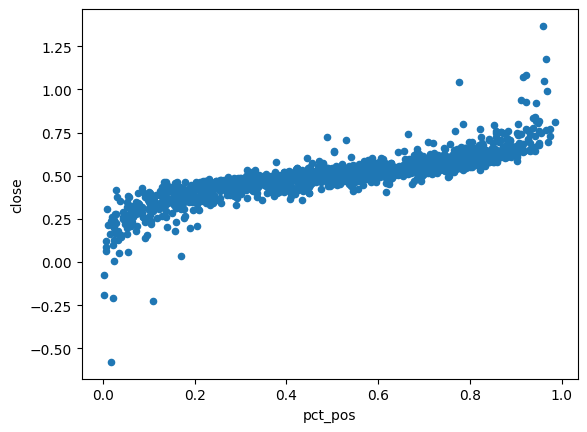

In [97]:
market_breadth_pd = (study_pd_diff>0)*1
market_breadth_pd =market_breadth_pd.sum(axis=1).to_frame(name="pos_count").join(market_breadth_pd.count(axis=1).to_frame(name="total_count"))\
                                .join(study_pd_diff.mean(axis=1).to_frame(name="mean_pnl")+0.5)
market_breadth_pd['pct_pos']=market_breadth_pd['pos_count']/market_breadth_pd['total_count']
market_breadth_pd=market_breadth_pd.join(study_pd_bench*10+0.5)
tf=1
market_breadth_pd.rolling(tf,min_periods=1).mean().plot.scatter(x='pct_pos',y='close')

<AxesSubplot:xlabel='date'>

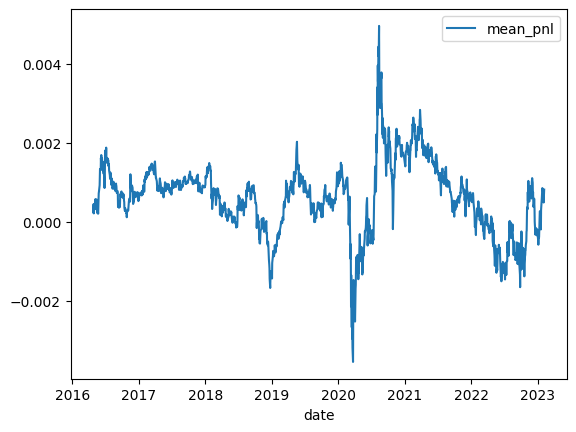

In [85]:

market_breadth_pd[['mean_pnl']].rolling(100,min_periods=100).mean().plot()

In [20]:
model = CausalModel(
    data=study_pd_diff,
    treatment='SPY',
    outcome='XLE')

[W 2023-03-10 21:39:14,043.043 dowhy.causal_model] Causal Graph not provided. DoWhy will construct a graph based on data inputs.
[W 2023-03-10 21:39:14,043.043 dowhy.causal_model] Relevant variables to build causal graph not provided. You may want to use the learn_graph() function to construct the causal graph.


In [21]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d           
──────(E[XLE])
d[SPY]        
Estimand assumption 1, Unconfoundedness: If U→{SPY} and U→XLE then P(XLE|SPY,,U) = P(XLE|SPY,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [19]:
causal_estimate = model.estimate_effect(identified_estimand,method_name="backdoor.propensity_score_stratification")
print(causal_estimate)

propensity_score_stratification


[E 2023-03-10 21:39:01,060.060 dowhy.causal_estimator] No common causes/confounders present. Propensity score based methods are not applicable


Exception: No common causes/confounders present. Propensity score based methods are not applicable